In [1]:
# NOTEBOOK IMPORTS
import os, glob, zipfile, warnings
import numpy as np
from tqdm.notebook import tqdm
from shutil import copyfile, rmtree
from datetime import datetime

# IMAGE IMPORTS
import cv2
from PIL import Image

# GIS IMPORTS
import fiona, pyproj
from affine import Affine
from shapely.geometry import shape, mapping, Point, LineString, MultiPolygon
from shapely.ops import transform, nearest_points, snap
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from scipy.spatial import cKDTree

# PLOTTING IMPORTS
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# CUSTOM UTILITIES
from WorldFileUtils import *
from GeometryUtils import *
from icp import *
from DataUtils import *
from FindGrid import *
from PlottingUtils import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")

In [2]:
def getGEOID(CID,):
    # DEALING WITH A COMMUNITY ID (CID)
    if CID >= 9e4:
        output = CIDs[CIDs["CID"] == CID]["GEOID_p"].to_numpy()
    else: # DEALING WITH A COUNTY
        output = np.asarray([CID])
    
    if output.size == 0:
        return None
    return output[0]

def getGeometry(geoid, new_epsg=3857):
    
    project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS(f'EPSG:{new_epsg}'), 
                                          always_xy=True).transform
    
    # DEALING WITH A COMMUNITY ID (CID)
    if geoid >= 9e4:
        output = places[places["GEOID"] == geoid]["geometry"].to_numpy()
    else: # DEALING WITH A COUNTY
        output = counties[counties["GEOID"] == geoid]["geometry"].to_numpy()
    if output.size == 0:
        return None    
    
    output = transform(project, output[0])
    
    return output

def drawGrid(image_t, out):
    # Create a blank image to draw the lines on
    line_image = np.zeros_like(image_t)

    for k, contours in out.items():
        contours = contours.squeeze()
        for i in range(contours.shape[0] - 1):
            start_point = tuple(contours[i, :])
            end_point = tuple(contours[i+1, :])
            color = (255)  # You can change the color (BGR format) as needed
            thickness = 10  # You can adjust the thickness of the line
            line_image = cv2.line(line_image, start_point, end_point, color, thickness)
            
    return line_image > 0

def adjustStep(from_points, coords_ras, kdtree, shear=True, rotation = True, perspective=True):
    
    # CALCULATE NEAREST POINTS AND FIND HOMOGRAPHY
    _, nearest_indices = kdtree.query(from_points)
    to_points = np.array([coords_ras[idx] for idx in nearest_indices])
    new_homography, _ = cv2.findHomography(from_points, to_points, cv2.RANSAC, 10000)
    if not shear:
        scale  = np.sqrt((new_homography[0, 0] ** 2 + new_homography[1, 1] ** 2) / 2)
        new_homography[0, 0] = scale 
        new_homography[1, 1] = scale
    if not perspective:
        new_homography[2, 0] = 0 
        new_homography[2, 1] = 0 
    if not rotation:
        new_homography[0, 1] = 0 
        new_homography[1, 0] = 0 
    final_points = new_homography @ np.vstack((from_points[:, 0], from_points[:, 1], np.ones(from_points[:, 0].shape)))
    
    return final_points[:2, :].T, new_homography

def find_bbox(binary_image):
    # Find the coordinates of all "True" elements in the binary image
    nonzero_points = cv2.findNonZero(binary_image)

    if nonzero_points is None:
        return None

    # Calculate the bounding rectangle for the "True" elements
    x, y, w, h = cv2.boundingRect(nonzero_points)

    return np.array([x, y, x+w, y+h])

def get_world_file_path(image_path):
    # Get the file extension (e.g., "png", "jpg", "tif")
    file_extension = image_path.split('.')[-1].lower()

    # Define a dictionary to map file extensions to world file extensions
    extension_mapping = {
        'png': 'pgw',
        'jpg': 'jpw',
        'jpeg': 'jpw',  # You can add more extensions if needed
        'tif': 'tfw',
        'tiff': 'tfw',
    }

    # Check if the file extension is in the mapping
    if file_extension in extension_mapping:
        # Replace the file extension with the corresponding world file extension
        world_file_extension = extension_mapping[file_extension]

        # Create the world file path by replacing the image file extension with the world file extension
        world_file_path = os.path.splitext(image_path)[0] + '.' + world_file_extension

        return world_file_path
    else:
        return None  # Unsupported file extension
    
def plotICP(reprojected_points, plot_skip=2, ):
    icp_iterations = len(reprojected_points)
    fig, ax = plt.subplots()
    colormap = plt.get_cmap('RdYlGn') 

    ax.scatter(coords_shp_proc[:, 0], coords_shp_proc[:, 1], color=colormap(0), s=0.5)
    ax.scatter(coords_ras_proc[:, 0], coords_ras_proc[:, 1], color="black", s=0.5)

    for i in np.arange(plot_skip, icp_iterations, plot_skip):
        ax.scatter(reprojected_points[i][:, 0], reprojected_points[i][:, 1], color=colormap(i / icp_iterations), s=0.1)
    return ax

IO dirs

In [3]:
username = os.getlogin()

if username == 'fhacesga':
    base_input_path   = r"D:\FloodChange\AAA_HistoricalDownload"
    base_output_path  = r"C:\Users\\"+username+"\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
 
CIDs     = pd.read_csv(f"{ref_dir}CountyCIDs.csv", index_col=0)
counties = gpd.read_file(f"{ref_dir}Counties.shp")
places   = gpd.read_file(f"{ref_dir}Places.shp")

counties["GEOID"] = counties["GEOID"].astype(np.int32)
places["GEOID"]   = places["GEOID"].astype(np.int32)

Create working dir and unzip all files

In [4]:
# proc_dir = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-08_16-35-58"
proc_dir = None
# proc_dir = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-11_14-00-13"
proc_dir = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-20_16-29-07"

In [5]:
if proc_dir is None:
    datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    proc_dir     = os.path.join(base_output_path, datetime_str)
    unzipped_dir = os.path.join(proc_dir, "Inputs")
    outputs_dir  = os.path.join(proc_dir, "Outputs")
    print(proc_dir)
    os.makedirs(proc_dir)
    os.makedirs(unzipped_dir)
    os.makedirs(outputs_dir)
    extractZipFiles(base_input_path, unzipped_dir)
else:
    unzipped_dir = os.path.join(proc_dir, "Inputs")
    outputs_dir  = os.path.join(proc_dir, "Outputs")
    rmtree(outputs_dir)
    os.makedirs(outputs_dir)

In [6]:
image_files = glob.glob(f"{unzipped_dir}/*")
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files = glob.glob(f"{unzipped_dir}/*IND*")

index_files.extend(filtered_files)
index_files = pd.DataFrame(index_files, columns=["FilePath"])

In [7]:
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)
index_files["GEOID"] = index_files["Location"].apply(getGEOID)
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)

In [8]:
index_files

,FilePath,Basename,Location,GEOID,geometry
0,C:\Users\fhacesga\Desktop\FIRMsDigitizing\proc...,480233IND0_0382.jpg,480233,4869908.0,(POLYGON ((-10637353.24214812 3452374.38747516...
1,C:\Users\fhacesga\Desktop\FIRMsDigitizing\proc...,480287IND0_0281.jpg,480287,48201.0,"POLYGON ((-10670735.8423667 3487438.181082066,..."
2,C:\Users\fhacesga\Desktop\FIRMsDigitizing\proc...,480287IND0_0288.jpg,480287,48201.0,"POLYGON ((-10670735.8423667 3487438.181082066,..."
3,C:\Users\fhacesga\Desktop\FIRMsDigitizing\proc...,480287IND0_0382.jpg,480287,48201.0,"POLYGON ((-10670735.8423667 3487438.181082066,..."
4,C:\Users\fhacesga\Desktop\FIRMsDigitizing\proc...,480287IND0_0985.jpg,480287,48201.0,"POLYGON ((-10670735.8423667 3487438.181082066,..."
...,...,...,...,...,...
80,C:\Users\fhacesga\Desktop\FIRMsDigitizing\proc...,485510B.tif,485510,4867688.0,POLYGON ((-10579345.43473218 3455313.758801992...
81,C:\Users\fhacesga\Desktop\FIRMsDigitizing\proc...,485513.tif,485513,4871960.0,POLYGON ((-10582980.01610658 3449596.838130131...
82,C:\Users\fhacesga\Desktop\FIRMsDigitizing\proc...,485513A.tif,485513,4871960.0,POLYGON ((-10582980.01610658 3449596.838130131...
83,C:\Users\fhacesga\Desktop\FIRMsDigitizing\proc...,485516.tif,485516,4876948.0,"POLYGON ((-10591605.6068507 3445133.552947415,..."


In [9]:
def FindGrid(image, classifications, effectiveArea, key, image_path, verbose=True):    
    
    # Detect lines
    lines, result_image, scale_x, scale_y, thinimage = line_detection(classifications, effectiveArea, image)
    writeImage(f"tempfiles/{filename}_01_linedetection.png", result_image, verbose)
    writeImage(f"tempfiles/{filename}_01_thinimage.png", thinimage, verbose)

    # FILTER BY MOST POPULAR ANGLES
    angles = calcAngles(lines)
    line_angles, line_indices, sorted_idx = filterLines_MostPopularAngles(np.array(angles), 0.5)
    
    # GET RESCALED LINES
    rescaled_lines_ordered = np.array(lines)[sorted_idx]
    filtered_lines = rescaled_lines_ordered[np.concatenate(line_indices).flatten()]
    
    if verbose:
        print("saving")
        plotLines(image, filtered_lines, savedir=f"tempfiles/{filename}_02_azimuthfiltering.png")

    # Extend lines to edges and filter by distance between lines
    extended_lines = extend_lines_to_edges(filtered_lines, image.shape)
    if verbose:
        plotLines(image, extended_lines, savedir=f"tempfiles/{filename}_03_lineextension.png")

    # Filter lines by distance between endpoints and re-extend
    min_distance = 50 * np.sqrt(scale_x ** 2 + scale_y ** 2)
    filtered_lines, filtered_idx = filter_lines_by_distance(extended_lines, min_distance)
    extended_lines = extend_lines_to_edges(filtered_lines, image.shape)
    if verbose:
        plotLines(image, extended_lines, savedir=f"tempfiles/{filename}_04_distancefiltering.png")

    # Clip lines
    lines_shp   = lines_to_linestrings(filtered_lines)
    split_lines = linestrings_to_lines(unary_union(lines_shp))
    if verbose:
        plotLines(image, extended_lines, savedir=f"tempfiles/{filename}_05_lineclipping.png")

    overlapping_lines, overlap_values = get_overlapping_lines(split_lines, 
                                                             thinimage, 
                                                             0.8,
                                                             verbose=verbose)
    
    if verbose:
        plotLines(image, overlapping_lines, savedir=f"tempfiles/{filename}_06_overlappinglines.png")
    
    # Convert lines to an image in which we identify contours
    bw_bounds = draw_lines_to_image(overlapping_lines, (image.shape[1], image.shape[0]))
    contours, hierarchy = cv2.findContours(bw_bounds, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    writeImage(f"tempfiles/{filename}_06_drawnimage.png", bw_bounds, verbose)
    highest_level = np.max(hierarchy, axis=1).flatten()[3]
    print(f"Highest Hierarchy: {highest_level} in {hierarchy.shape[1]} contours")
    
    # Test which squares are identified
    if verbose:
        filled_image = np.zeros(image.shape)
        
        # Fill innermost contours with random colors
        for idx, contour in enumerate(contours):
            
            if hierarchy[0][idx][3] == highest_level:  # If contour has no child contours
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                cv2.drawContours(filled_image, [contour], -1, color, thickness=cv2.FILLED)
        writeImage(f"tempfiles/{filename}_06_recognizedsquares.png", filled_image, verbose)


    # Find which squares have a given text
    outdict = {}
    for idx, contour in tqdm(enumerate(contours), total=len(contours), disable=~verbose):
        if hierarchy[0][idx][3] == highest_level:  # If contour has no child contours
            x, y, w, h = cv2.boundingRect(contour)
        
            # Crop the contour region from the image
            if image.ndim == 3:
                cropped_region = image[y:y+h, x:x+w, 0]
            else: 
                cropped_region = image[y:y+h, x:x+w]
            cropped_region = pad_image_with_percentage(cropped_region, 20, 20)
            
            writeImage(f"tempfiles/{filename}_07_{idx}.png", cropped_region, verbose)
            
            # Perform OCR using pytesseract
            ocr_text = pytesseract.image_to_string(cropped_region,
                                                  config='--psm 12 --oem 3')
                                                  # -c tessedit_char_whitelist=0123456789
            
            if len(ocr_text) == 0:
                continue
                
            text = find_word_with_key(ocr_text, key, verbose=verbose)
            
            if text is None:
                continue
            
            if isinstance(text, list):
                print("Found too many names! Splitting along longest sides")
                try:
                    shapely_contour = contours_to_shapely_polygons(contour)
                    outpoly_1, outpoly_2 = splitPolygonByLongerSides(shapely_contour)
                    
                    outdict[text[0]] = convertShapelyToCV2(outpoly_1)
                    outdict[text[1]] = convertShapelyToCV2(outpoly_2)
                except:
                    print("Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified")
                    continue
                continue
            outdict[text] = contour
    
    plt.clf()
    
    return outdict


In [10]:
def getBoundaryPoints(row):
    # GET WHICHEVER POLYGON IS THE LARGEST IN THE ROW'S GEOMETRY AND SIMPLIFY
    if row["geometry"] is None:
        return None
    elif isinstance(row["geometry"], MultiPolygon):
        largest_polygon_area = np.argmax([a.area for a in row["geometry"]])
        largest_polygon = row["geometry"][largest_polygon_area].simplify(tolerance=20)
        largest_polygon = largest_polygon.boundary
    else:
        largest_polygon = row["geometry"].boundary
    
    # CONVERT POLYGON TO POINTS
    length = largest_polygon.length # POLYGON LENGTH
    point_boundary_list = list()    # OUTPUT POINT LIST
    
    # INTERPOLATE THROUGH ALL OF LENGTH
    for distance in tqdm(range(0,int(length),20), disable=True):         
        point = largest_polygon.interpolate(distance)   
        point_boundary_list.append(point)
    point_boundary_gdf = gpd.GeoDataFrame(geometry=point_boundary_list)
    
    # SHAPEFILE BOUNDS
    shp_bounds = [i for i in largest_polygon.bounds]
    return point_boundary_gdf, shp_bounds

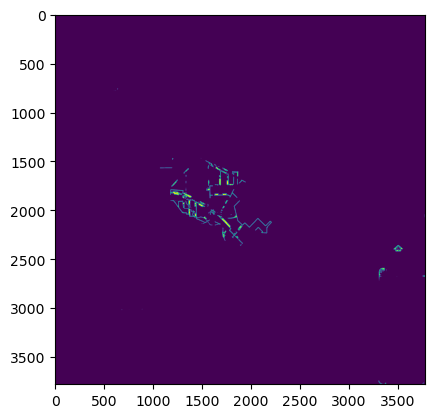

In [18]:
plt.imshow(classifications[:, : ,1])

In [13]:
verbose = True

TPNN = None
RLNN = None

for i, row in index_files.iterrows():
    print(row["FilePath"])
    
    filename = os.path.basename(row["FilePath"])
    
    # READ FILES AND RUN CLASSIFICATIONS
    image = cv2.imread(row["FilePath"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # SAVE IMAGE TO OUTPUT DIRECTORY
    output_image = os.path.join(outputs_dir, filename)
    copyfile(row["FilePath"], output_image)
    
    # GET BOUNDARY POINTS FROM RESPECTIVE SHAPEFILE
    point_boundary_gdf, shp_bounds = getBoundaryPoints(row)
    if point_boundary_gdf is None:
        continue
    
    # WHAT ARE WE LOOKING FOR IN EACH IDENTIFIED SQUARE?
    key = findKey(row["Basename"])    
    if key is None:
        print(f"Could not find key in {filename}")
        
    # RUN IMAGES THROUGH CNNs
    classifications, TPNN  = findKeypoints(image, model=TPNN)
    effectiveArea, RLNN    = findSquares(image, model=RLNN)
    cv2.imwrite(f"tempfiles/{filename}_00_classification.png", np.asarray(probability_to_rgb(classifications)))
    cv2.imwrite(f"tempfiles/{filename}_00_effectiveArea.png", np.asarray(probability_to_rgb(effectiveArea)))
    error
    # FIND THE GRID INSIDE THE IMAGE
    out = FindGrid(image, classifications, effectiveArea, key, row["FilePath"], verbose=True)
    
    # PLOT IMAGE
    plot_image = np.dstack([image, image, image])
    contours = []
    
    
    # LOOP THROUGH CONTOURS AND ADD THEM TO IMAGE
    for k, v in out.items():
        cv2.drawContours(plot_image, v, -1, (0, 255, 0), 3)
        contours.append(contours_to_shapely_polygons(v))
        
    # CALCULATE BOUNDS OF CONTOURS ON IMAGE
    bounds_panels = MultiPolygon(contours).bounds
    bounds_panels = [int(i) for i in bounds_panels]

    # CREATE MASK USING GRID 
    mask = np.zeros(image.shape)
    mask[bounds_panels[1]+50:bounds_panels[3]-50, bounds_panels[0]+50:bounds_panels[2]-50] = 1
    mask_1 = drawGrid(image, out)          # GRID MASKING
    mask = np.logical_and(~mask_1, mask)   # MERGE MASKS
    
    # FLIP IMAGE AND MASK IT
    image = 255 - image
    image_t = image * mask
    
    # RASTER BOUNDS
    get_bounds_image = np.where(np.asarray(cv2.erode(image_t, np.ones((3,3), np.uint8)) > 50), 1, 0)
    # plt.imshow(get_bounds_image)
    # plt.show()
    
    # print(get_bounds_image)
    bounds_panels_postfilter = find_bbox(get_bounds_image)
    bounds_panels = [i for i in bounds_panels_postfilter]

    print("Assigning Points")
    # INITIAL TRANSFORM
    from_points   = np.array([[bounds_panels[0], bounds_panels[1]], 
                   [bounds_panels[0], bounds_panels[3]],
                   [bounds_panels[2], bounds_panels[1]],
                   [bounds_panels[2], bounds_panels[3]]])

    to_points = np.array([[shp_bounds[0], shp_bounds[1]], 
                   [shp_bounds[0], shp_bounds[3]],
                   [shp_bounds[2], shp_bounds[1]],
                   [shp_bounds[2], shp_bounds[3]]])

    initial_transform = cv2.findHomography(from_points, to_points, cv2.RANSAC, 1000)
    original_homography = initial_transform[0]
    inverse_transform = np.linalg.inv(original_homography)

    # CONVERT THINNED IMAGE TO POINTS
    thin_image = cv2.ximgproc.thinning(image_t.astype(np.uint8), thinningType=cv2.ximgproc.THINNING_GUOHALL)
    y, x = np.where(thin_image[::-1, :])                   # GET COORDINATES OF EVERY 
    image_points = np.vstack((x, y, np.ones(x.shape)))     # STACK X, Y, AND Z COORDINATES
    # outputs = original_homography @ image_points           # TRANSFORM COORDINATES USING ESTIMATES
    
    # TRANSFORM SHAPEFILE POINTS INTO IMAGE COORDINATE SYSTEM
    point_geometry = [[point.geometry.x, point.geometry.y, 1] for i, point in point_boundary_gdf.iterrows()]
    point_geometry = inverse_transform @ np.array(point_geometry).T
    
    # COORDINATE HANDLING
    coords_shp = point_geometry.T
    coords_ras = np.vstack((image_points[0, :], image_points[1, :], np.ones(image_points[1, :].shape))).T
    
    # IMAGE ORIGIN COORDINATE SYSTEM TO IMAGE CENTER COORDINATE SYSTEM
    offsets = np.mean(coords_ras, axis=0)
    x_offset = offsets[0]
    y_offset = offsets[1]

    coords_shp_proc = np.vstack((coords_shp[:, 0] - x_offset, coords_shp[:, 1] - y_offset)).T
    coords_ras_proc = np.vstack((coords_ras[:, 0] - x_offset, coords_ras[:, 1] - y_offset)).T
    
    # FAST SEARCH STRUCTURE
    kdtree = cKDTree(coords_ras_proc)
    
    # ITERATIVE CLOSEST POINT
    reprojected_points = []
    compounded_homography = np.eye(3)
    proc_points = coords_shp_proc
    
    # ITERATE
    for i in tqdm(range(20), disable=True):
        # TAKE ADJUSTMENT STEP
        out, new_homography = adjustStep(proc_points, coords_ras_proc, kdtree,
                                        shear=False, rotation=False, perspective=False)
        compounded_homography = compounded_homography @ new_homography
        reprojected_points.append(out)
        proc_points = out
        if i % 10 == 0:
            scale  = np.sqrt((new_homography[0, 0] ** 2 + new_homography[1, 1] ** 2) / 2)
            offset = np.sqrt((new_homography[1, 2] ** 2 + new_homography[0, 2] ** 2) / 2)

            print(f"Scale: {scale:.2f} Offset: {offset:.2f}")
    
    plotICP(reprojected_points, plot_skip=10, )
    plt.show()
    
    # REVERSE Y AXIS
    rev_y_axis = np.array([[1, 0, 0],
                           [0,-1, 0],
                           [0, 0, 1]])

    # move = original_homography @ np.array([0, image_t.shape[0], 0])
    translation = np.eye(3)
    translation[1, 2] = image_t.shape[0]

    adjustment = np.linalg.inv(compounded_homography.copy())
    adjustment[0, 2] = -1 * adjustment[0, 2]
    adjustment[1, 2] = -1 * adjustment[1, 2]
    # temp = adjustment[0, 2]
    # adjustment[0, 2] = adjustment[1, 2]
    # adjustment[1, 2] = temp
    output_transform = original_homography @ adjustment @ translation @ rev_y_axis 
    print(output_transform)
    # output_transform = original_homography @ translation @ rev_y_axis 
      
    output_affine = Affine(*output_transform.flatten()[:6])
    write_world_file_from_affine(output_affine, get_world_file_path(output_image))
    

C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-09-20_16-29-07\Inputs\480233IND0_0382.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

NameError: name 'error' is not defined